The first thing in order is to define the function of the WTD, which for this simple case is:

$$ W(t) = \sum_n n \rho_{nn} e^{-n\gamma t}$$

In [1]:
using LinearAlgebra
import Plots
import Roots # Root finding, I am using root_find
import Random
import StatsBase

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] 
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


In [113]:
function wtd(rho, t)
    N = size(rho)[1]
    ns = LinRange(0, N-1, N) 
    probs = diag(rho, 0)
    weights = (probs) .* exp.(-t.*ns)
    sum = dot(weights, ns)
    return real(sum)
end 

wtd (generic function with 1 method)

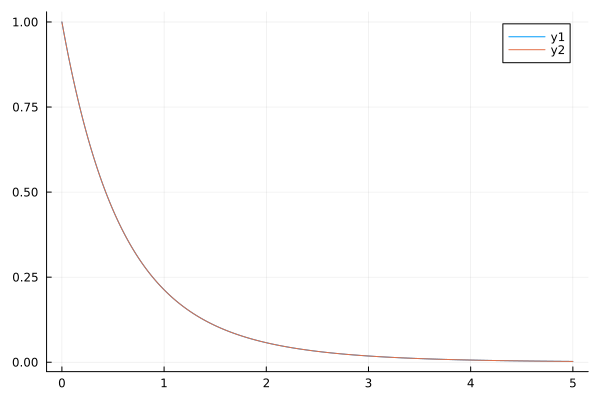

In [147]:
# Testing the WTD implementation
rho_0 = 1/3 .* ones(3,3)
f(t) = wtd(rho_0, t) # Implementation
g(t) = (exp(-t) + 2*exp(-2*t))/3 # Theoretical
t = collect(LinRange(0,5,1000))
y1 = f.(t)
y2 = g.(t)
plot(t, [y1 y2])

Next thing is implementing a sampling routine, I'll go with inversion sampling since for this case it's possible to access 
the CDF:

$$ F(t) = \sum_n \rho_{nn}(1-e^{-n\gamma t})$$

**Remark: if the state contains vacuum componenets the CDF won't go to 1 in** $\gamma t \to \infty$

In [151]:
function cdf(rho, t)
    N = size(rho)[1]
    ns = LinRange(0, N-1, N) 
    probs = diag(rho, 0)
    weights =  (1 .- exp.(-t.*ns))
    sum = dot(weights, probs)
end 

cdf (generic function with 1 method)

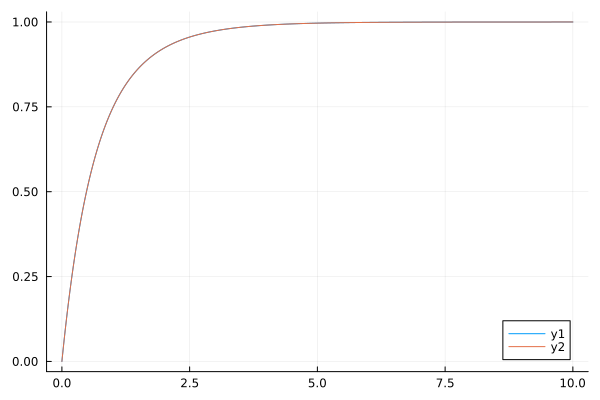

In [164]:
# Testing the CDF implementation
rho_0 = 1/2 .*  [[0, 0, 0] [0, 1, 1] [0, 1, 1] ]
f(t) = cdf(rho_0, t) # Implementation
g(t) = 0.5 * (1-exp(-t)) + 0.5 * (1-exp(-2*t))  # Theoretical
t = collect(LinRange(0,10,1000))
y1 = f.(t)
y2 = g.(t)
plot(t, [y1 y2])

In [105]:
################# SAMPLING ROUTINE #################
# 1. Inverse Function
# The strategy will consists in using a root finding algorithm 
# Arguments: the function for which we want the inverse and the point
# Returns: f^{-1}(t)
function inverse_f(f, t)
    g(x) = f(x) - t 
    a = 0
    b = 30 # The final time must be long enough 
    root = Roots.find_zero(g, (a, b), Bisection() ) 
    return root 
end 
# 2. Sampling Routine
# I'll use inverse sampling
# Arguments : the CDF of the distribution we are sampling
function generate_sample(f, seed=1)
    Random.seed!(seed)
    u = rand() 
    return inverse_f(f, u)
end 

generate_sample (generic function with 3 methods)

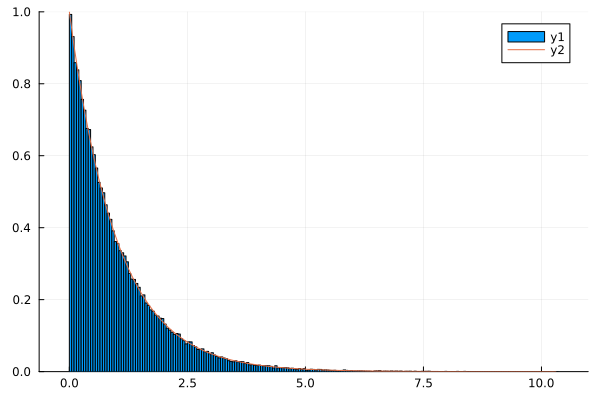

In [113]:
# Test of the sampler
f(t) = 1-exp(-t)
N = 100000
sample = ones(N)
for k in range(1, N)
    sample[k] = generate_sample(f, k)
end 
histogram(sample, normalize=:pdf)
x = LinRange(0, maximum(sample), 100)
plot!(x, exp.(-x))

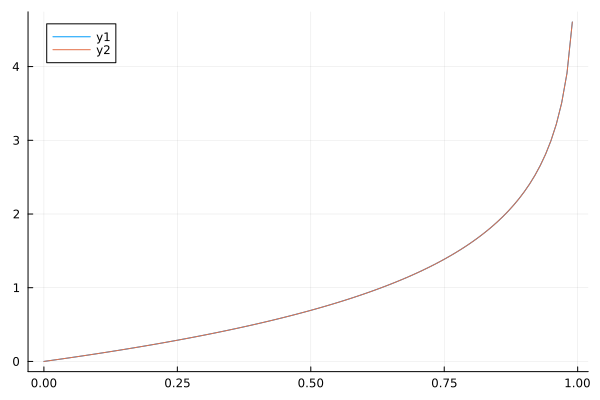

In [29]:
# Test of the inverse
f(t) = 1-exp(-t)
g(t) = -log(1-t)
x = LinRange(0, 0.99, 100) # Notice the maximum time most be long enough
f_inverse(t) = inverse_f(f, t)
plot(x, [g.(x) f_inverse.(x)])


In [197]:
# The Algorithm
# Now that all the pieces are ready, we can run the algorithm

################### Setup ###############################
### Simulation conditions
NSAMPLES = 100000 # Number of points in the fine-grid, for the precomputation
seed = 1 # Seed, clearly
W = zeros(NSAMPLES);
EPS = 1e-3
NTRAJ = 50 # Number of trajectories
tf = 1 # Final time
# Paramters
gamma = 1
# Initial State
psi0 = zeros(2)
psi0[2] = 1 # Initial condition
# Jump Operators and related
sigma_m = [[0.0+0im, 0]  [1, 0]]
L1 = sqrt(gamma) * sigma_m
J = adjoint(L1)*L1
H_eff = -0.5im * J
expH_eff(tau) = exp(-1im*H_eff*tau) # Exponential of -i*tau*H_eff


expH_eff (generic function with 1 method)

In [209]:
################### Precomputation ######################
# Following Radaelli's advice, I'll choose a fine grid of time 
# To precompute J
multiplier = 10 # Factor to multiply by tf and create the sample
ts = LinRange(0, multiplier*tf, NSAMPLES)
Qs = Vector{Matrix{ComplexF64}}(undef, NSAMPLES)
dt = multiplier*tf/NSAMPLES
for k in 1:NSAMPLES
    expm = expH_eff(ts[k]) 
    Qs[k] = expm * J * adjoint(expm)
end 

In [234]:
############### Running the Trajectory #################
# 0. Set Initial condition
    psi = zeros(2)
    psi = psi0
    t = 0
    while t < tf
    # 1. Calculate the WTD for the state, these act as weights
        for k in 1:NSAMPLES
           W[k] = dot(conj.(psi), Qs[k]*psi) 
        end 
        # 0.a We must verify if we got a dark state, that can be cheked by 
        # looking at the normalization of the QTD
        if abs(sum(W)*dt - 1) > EPS
            print("Dark State Reached in last jump", " ", psi)
            print(sum(W)*dt, "\n")
            break
        end 
        # 2. Sample jump time
        tau = StatsBase.sample(ts, weights(W))
        t = tau + t
        if t>tf
            print("Next jump happens after tf\n")
            psi_tilde = expH_eff(tf-t) * psi
            psi = psi_tilde / norm(psi_tilde)
            print(tf, psi)
            break
        end 
        print(tau, psi)
        psi_tilde = expH_eff(tau) * L1*psi # State without normalization
        psi = psi_tilde / norm(psi_tilde)
    end 

0.9999946036275371
0.22570225702257024[0.0, 1.0]0.0
Dark State Reached in last jump ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]0.0
